In [23]:
# Libraries 

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
import seaborn as sns
import matplotlib.pyplot as plt


Clustering 87k physicians... calculating WCSS.


c:\Users\Usuario\anaconda3\envs\pharmareach\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


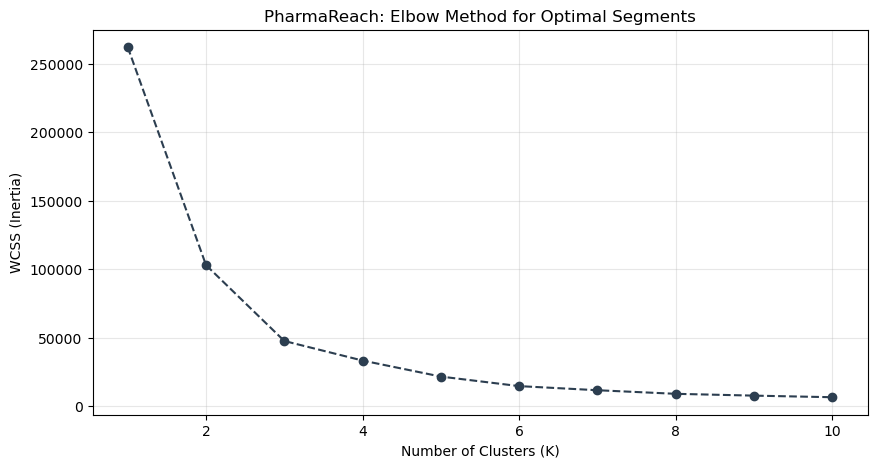

In [17]:
# 2. Re-connect & Load
DB_PATH = "../data/processed/HVT_Analysis_Final.db"
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM Physician_Nexus_Model", conn)
conn.close()

# 3. Scale the features
features = ['influence_ratio', 'log_total_spend', 'mfg_loyalty_pct']
X = df[features]
X_scaled = StandardScaler().fit_transform(X)

# 4. The Elbow Plot (with Threading Protection)
wcss = []
print("Clustering 87k physicians... calculating WCSS.")

with threadpool_limits(limits=1, user_api='blas'):
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

# 5. Visualize
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', color='#2c3e50', linestyle='--')
plt.title('PharmaReach: Elbow Method for Optimal Segments', fontsize=12)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# 1. K based on plot 
optimal_k = 3 

# 2. Run the final K-Means
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(X_scaled)

# 3. See the "Personality" of each cluster
cluster_summary = df.groupby('cluster')[features].mean()

print("--- CLUSTER PROFILES (Means) ---")
print(cluster_summary)

# 4. Count how many physicians are in each group
print("\n--- PHYSICIAN COUNT PER SEGMENT ---")
print(df['cluster'].value_counts())

--- CLUSTER PROFILES (Means) ---
         influence_ratio  log_total_spend  mfg_loyalty_pct
cluster                                                   
0               0.000126         4.421481        99.987356
1               0.800870         8.898911        19.912997
2               0.004642         7.821621        99.535764

--- PHYSICIAN COUNT PER SEGMENT ---
cluster
0    55496
2    30810
1      991
Name: count, dtype: int64


c:\Users\Usuario\anaconda3\envs\pharmareach\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


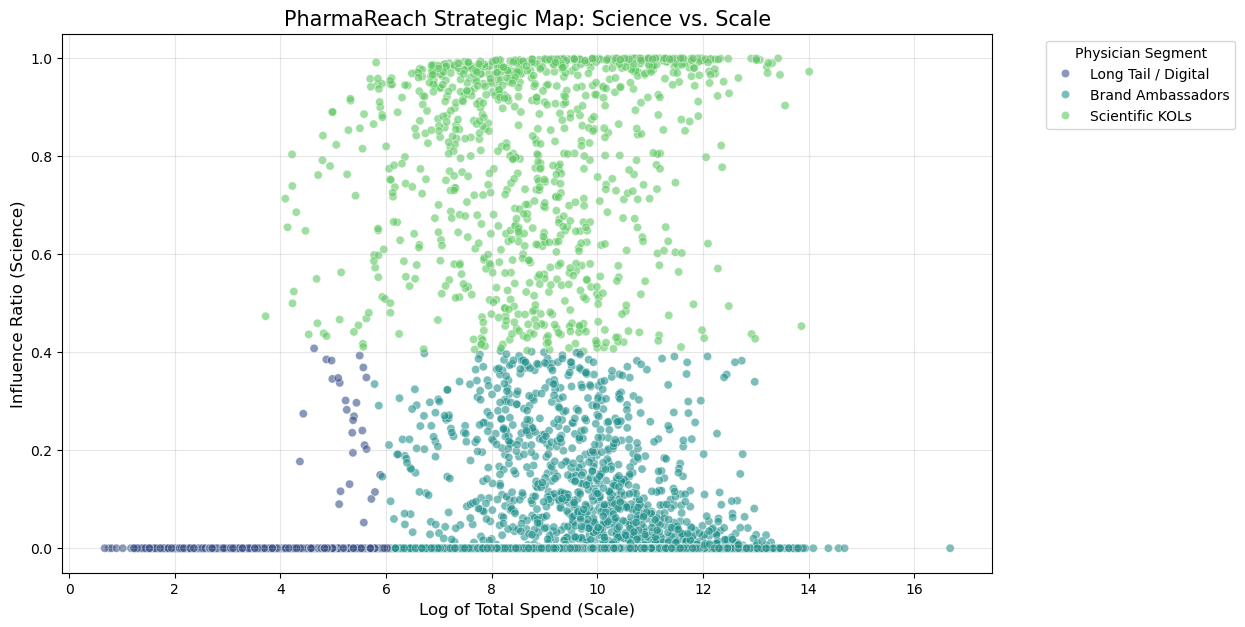

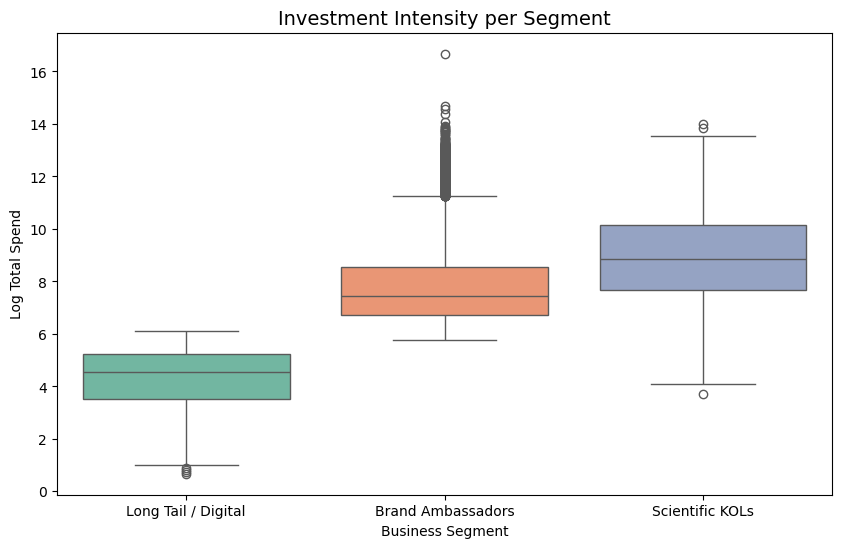

In [25]:
# 1. Map the Cluster numbers to their Business Names for Clarity
cluster_map = {
    1: 'Scientific KOLs',
    2: 'Brand Ambassadors',
    0: 'Long Tail / Digital'
}
df['segment_name'] = df['cluster'].map(cluster_map)

# --- VIZ 1: The Strategy Map (Scatter Plot) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df, 
    x='log_total_spend', 
    y='influence_ratio', 
    hue='segment_name', 
    palette='viridis', 
    alpha=0.6
)
plt.title('PharmaReach Strategic Map: Science vs. Scale', fontsize=15)
plt.xlabel('Log of Total Spend (Scale)', fontsize=12)
plt.ylabel('Influence Ratio (Science)', fontsize=12)
plt.legend(title='Physician Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# --- VIZ 2: Investment Intensity (Boxplot) ---

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='segment_name', 
    y='log_total_spend', 
    data=df, 
    hue='segment_name',     # Assigning hue to the x variable
    palette='Set2', 
    legend=False            # Hiding the legend since it's redundant here
)
plt.title('Investment Intensity per Segment', fontsize=14)
plt.ylabel('Log Total Spend')
plt.xlabel('Business Segment')
plt.show()

##### Save Table

In [26]:
conn = sqlite3.connect("../data/processed/HVT_Analysis_Final.db")
df.to_sql('Physician_Nexus_Final_Strategy', conn, if_exists='replace', index=False)
conn.close()

print("Table saved successfully!")

Table saved successfully!
